# Constrained Fine Structure
This notebook shows the comparison between the constrained and unconstrained fine structure fit in the model-based approach for EELS quantification. More information on the methodology can be found in [Jannis et al](https://arxiv.org/abs/2408.11870)

In [ ]:
%matplotlib qt #opens new window, necessary for interactive plotting

In [1]:
import pyEELSMODEL.api as em
import matplotlib.pyplot as plt
import os
import numpy as np

from pyEELSMODEL.components.linear_background import LinearBG
from pyEELSMODEL.components.gdoslin import GDOSLin
from pyEELSMODEL.components.constrained_gdoslin import ConstrainedGDOSLin
from pyEELSMODEL.components.MScatter.mscatterfft import MscatterFFT

In [2]:
def do_fine_structure_fit(s, ll, elements, edges, onsets, ewidths, ns, settings, method):
    """
    Small function which wraps the fitting of the multispectrum or just a single spectrum

    Args:
        s (MultiSpectrum): The multispectrum which needs to be fitted. 
        ll (MultiSpectrum): The low-loss multispectrum
        elements (list): List of elements which are present in the spectrum
        edges (list): List of edges which are present in the spectrum,
            should match with elements
        onsets (list): Onset energies of the atomic cross sections
        ewidths (list): The extend of the fine structures
        ns (list): The number of parameters for each fine structure
        settings (list): E0 (V), alpha (radians), beta (radians)
        method (str): Indicate if fine structure should be constrained or not
    """
    
    specshape=s.get_spectrumshape()

    E0 = settings[0]
    alpha = settings[1]
    beta = settings[2]

    #the background is modelled with a power op 3 for convenience
    BG = LinearBG(specshape, rlist=[3])
    BG.use_approx = None

    comp_elements = []
    comp_fine = []
    for edge, element, onset, interval, n in zip(edges, elements, onsets, ewidths, ns):
        # comp = HydrogenicCoreLossEdge(specshape, 1, E0, alpha, beta, element, edge, eshift=onset)

        comp = em.ZezhongCoreLossEdgeCombined(specshape, 1, E0, alpha, beta, 
                                              element, edge, eshift=onset, q_steps=20)

        comp_elements.append(comp)
        if method == 'constrained':
            fine = ConstrainedGDOSLin.gdoslin_from_edge(specshape, comp, ewidth=interval,degree=n,
                                interpolationtype='nearest', pre_e=0)
        else:
            fine = GDOSLin.gdoslin_from_edge(specshape, comp, ewidth=interval,degree=n,
                                            interpolationtype='nearest', pre_e=0)

        comp_fine.append(fine)
        
    llcomp = MscatterFFT(specshape, ll)
    components = [BG] + comp_elements + comp_fine + [llcomp]
    Omod = em.Model(specshape, components=components)
    fit = em.QuadraticFitter(s, Omod)  # The fitter object
    
    if type(s) is em.MultiSpectrum:
        fit.multi_fit()
        fitsig = fit.model_to_multispectrum()
        fig, maps, name = fit.show_map_result(comp_elements)

        return fit, fitsig, maps

    else:
        fit.perform_fit()
        fit.set_fit_values()
        return fit


In [3]:
cdir = os.getcwd()
print('Current directory is: ' + cdir)

Current directory is: c:\Users\daen.jannis1\Documents\pyEELSMODEL\examples


## Simulated Carbon K edge
The loaded data is a simulated carbon K edge on which fine structure is added. This fine structure is made such that the constrains derived from the Bethe sum rule apply. This example is used to showcase the improvement of precision when using the constrained fine structure model. In this simulation, the background is a pure power-law with power 3.  

In [4]:
filename = os.path.join(cdir, 'data', 'simulated_C_edge.hdf5')
filenamell = os.path.join(cdir, 'data', 'll_simulated_C_edge.hdf5')

In [5]:
s0 = em.Spectrum.load(filename)
ll = em.Spectrum.load(filenamell)

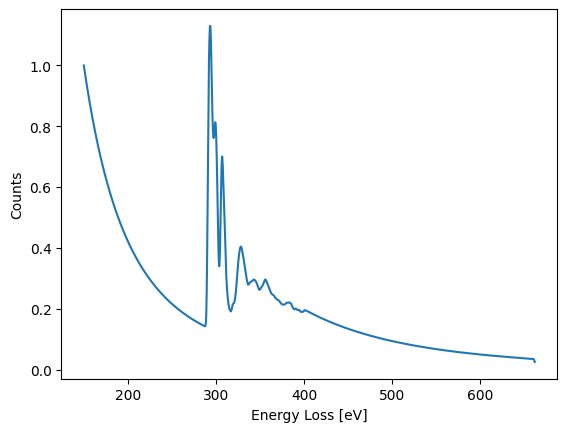

In [6]:
s0.plot()

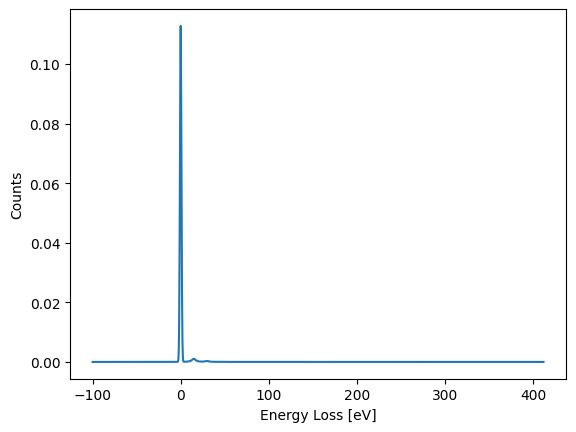

In [7]:
ll.plot()

The settings used for the calculation of the atomic cross section and fine structure. 

In [8]:
E0 = 300e3 #acceleration voltage
beta = 20e-3 #collection angle
alpha= 1e-9 #convergence angle (parallel beam)
settings = [E0, alpha, beta]

elements = ['C']
edges = ['K']
onsets = [6] #onset energy of the atomic cross section compared to the literature value
ewidths= [110] #how far the fine structure should extend
ns = [110] #number of basis functions for the fine structure

## Simulation: Different noise levels
Here poisson noise is added to the ground-truth spectrum. This is used to showcase how both constrained and unconstrained methods behave at different noise levels

In [13]:
nsamples = 2000 #how many samples of one noise level
nnoise = 2**(np.arange(20)+1) #noise levels
nnoise = 1*nnoise/nnoise[0] #normalize to the first noise level

mdata = np.zeros((nnoise.size, nsamples, s0.size))

for jj in range(nnoise.size):
    sig = nnoise[jj] * s0.data

    for ii in range(nsamples):
        mdata[jj,ii] = np.random.poisson(sig)

mspec = em.MultiSpectrum.from_numpy(mdata, s0.energy_axis)

In [9]:
em.MultiSpectrumVisualizer([mspec[:20,:20,:]]) #visual inspection of how the data looks like

c:\users\daen.jannis1\documents\pyeelsmodel\pyEELSMODEL\operators\multispectrumvisualizer.py:119: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


### Fitting on average spectrum
Both methods are used to fit the average spectrum. 

In [14]:
single_fitn = do_fine_structure_fit(mspec.mean(), ll, elements,
                                            edges, onsets, ewidths, ns, settings, None)
single_fitc = do_fine_structure_fit(mspec.mean(), ll, elements,
                                            edges, onsets, ewidths, ns, settings, "constrained")

hll


cannot use analytical gradients since a convolutor is inside model


hll


cannot use analytical gradients since a convolutor is inside model


Parallel incoming beam is used
collection angle is: 0.02
voila


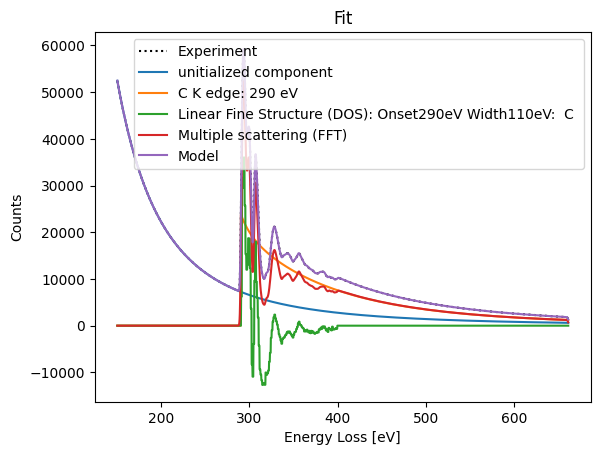

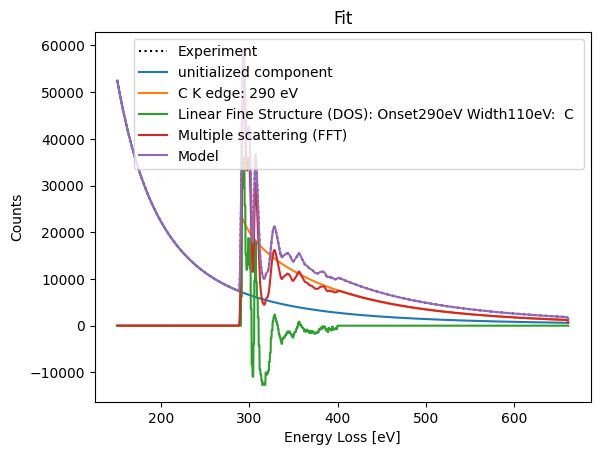

In [26]:
fig1 = single_fitn.plot()
fig2 = single_fitc.plot()

### Fitting multispectrum
Both methods are used for the multispectrum. Note that it fits 40 000 spectra so it can take several tens of minutes.

hll


cannot use analytical gradients since a convolutor is inside model
40000it [11:50, 56.32it/s]
40000it [00:26, 1521.17it/s]


hll


cannot use analytical gradients since a convolutor is inside model


Parallel incoming beam is used
collection angle is: 0.02


4it [00:00, 32.63it/s]

voila


40000it [12:37, 52.81it/s]
40000it [00:23, 1710.07it/s]


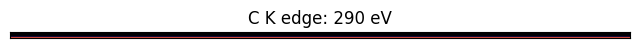

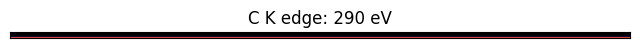

In [18]:
fitn, fitsign, mapn = do_fine_structure_fit(mspec, ll, elements,
                                            edges, onsets, ewidths, ns, settings, None)
fitc, fitsigc, mapc = do_fine_structure_fit(mspec, ll, elements,
                                            edges, onsets, ewidths, ns, settings, "constrained")

In [24]:
#visualization of the fitting results
em.MultiSpectrumVisualizer([mspec[:20,:20,:], fitsigc[:20,:20,:], fitsign[:20,:20,:]])

c:\users\daen.jannis1\documents\pyeelsmodel\pyEELSMODEL\operators\multispectrumvisualizer.py:119: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


Cannot make square larger
Cannot make square larger
Cannot make square larger
Cannot make square larger
Cannot make square larger
Cannot make square larger


### Results
The first image (left) shows the average value obtained from the atomic cross section as a function of noise level. Both methods do not show any bias which is expected since the model is known a priori. The right image shows the standard deviation on the elemental abundance and this shows a clear advantage for the constrained method which shows a smaller standard deviation.

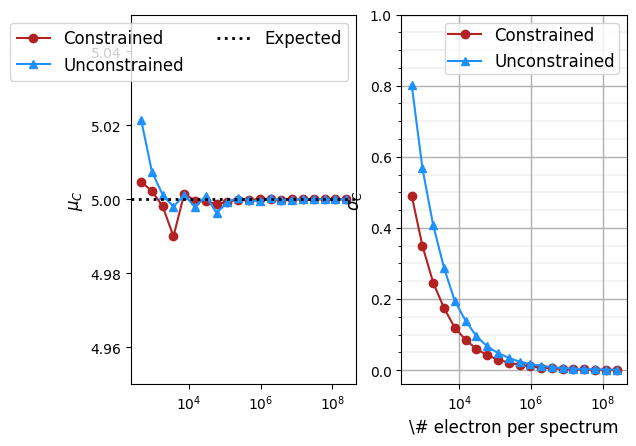

In [33]:
fig, ax = plt.subplots(1,2)

xaxis=mspec.multidata.sum(2).mean(1)
cte=1e3
fs=12

ax[0].plot(xaxis, cte*mapc[0].mean(1)/nnoise, label='Constrained', marker='o', color='firebrick')
ax[0].plot(xaxis, cte*mapn[0].mean(1)/nnoise, label='Unconstrained', marker='^', color='dodgerblue')

ax[0].set_xscale('log')
ax[0].set_ylim([4.95, 5.05])
ax[0].axhline(cte*0.005, color='black', linestyle='dotted', linewidth=2, label='Expected')
ax[0].set_ylabel(r'$\mu_{C}$', fontsize=fs)
ax[0].legend(fontsize=fs, loc='upper right', ncol=2)

ax[1].plot(xaxis, cte*mapc[0].std(1)/nnoise, label='Constrained', marker='o', color='firebrick')
ax[1].plot(xaxis, cte*mapn[0].std(1)/nnoise, label='Unconstrained', marker='^', color='dodgerblue')
ax[1].legend(fontsize=fs, loc='upper right', ncol=1, borderpad=0.2)

ax[1].set_xscale('log')
# ax[1].set_yscale('log')
ax[1].set_ylabel(r'$\sigma_{C}$', fontsize=fs)
ax[1].set_ylim([None, 1])


for axe in ax[1:]:
    axe.set_xlabel(r'\# electron per spectrum', fontsize=fs)
    axe.grid(which = "major", linewidth = 1)
    axe.grid(which = "minor", linewidth = 0.2)
    axe.minorticks_on()